Get Bicubic x4 data

In [ ]:
#!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip
#!unzip /content/DIV2K_train_LR_bicubic_X4.zip

!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip
!unzip /content/DIV2K_valid_LR_bicubic_X4.zip

!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!unzip /content/DIV2K_train_HR.zip

!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
!unzip /content/DIV2K_valid_HR.zip

--2021-09-23 18:07:17--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip [following]
--2021-09-23 18:07:18--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31505881 (30M) [application/zip]
Saving to: ‘DIV2K_valid_LR_bicubic_X4.zip’

DIV2K_valid_LR_bicu 100%[===================>]  30.05M  11.1MB/s    in 2.7s    

2021-09-23 18:07:21 (11.1 MB/s) - ‘DIV2K_valid_LR_bicubic_X4.zip’ saved [31505881/31505881]

Archive:  /content/DIV2K_valid_LR_bicubic_X4.zip
   creating: DIV2K_

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import pdb

Generator and Discriminator models

In [2]:
import functools
from functools import reduce
import operator
from operator import __add__

#Pytorch does not support same padding for strided convolutional layers, so this is needed
class Conv2dSamePadding(nn.Conv2d):
    def __init__(self,*args,**kwargs):
        super(Conv2dSamePadding, self).__init__(*args, **kwargs)
        self.zero_pad_2d = nn.ZeroPad2d(functools.reduce(operator.__add__,
                  [(k // 2 + (k - 2 * (k // 2)) - 1, k // 2) for k in self.kernel_size[::-1]]))

    def forward(self, input):
        return  self._conv_forward(self.zero_pad_2d(input), self.weight, self.bias)

class ResidualBlock(nn.Module):    

    def __init__(self, in_channels, out_channels=64, stride=1, downsample=None):
        super().__init__()
        self.conv1 = Conv2dSamePadding(in_channels, out_channels, kernel_size=3, stride=stride,
                     bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.prelu = nn.PReLU()
        self.conv2 = Conv2dSamePadding(out_channels, out_channels, kernel_size=3, stride=1,
                     bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity #Skip connection
        #out = self.relu(out)

        return out

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, downsample=None):
        super().__init__()
        self.conv = Conv2dSamePadding(in_channels, out_channels, kernel_size=3, stride=stride,
                      bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.lrelu = nn.LeakyReLU()

    def forward(self, x):

        out = self.conv(x)
        out = self.bn(out)
        out = self.lrelu(out)

        return out

class Generator(nn.Module):
    def __init__(self, blocks=16, downsample=None):
        super().__init__()
        #Three input channels (RGB)
        self.conv1 = Conv2dSamePadding(3, 64, kernel_size=9, stride=1,
                     bias=False)
        self.prelu = nn.PReLU()
        self.blocks = nn.ModuleList([ResidualBlock(in_channels=64) for i in range(blocks)])

        #Conv layers to increase resolution
        self.conv2 = Conv2dSamePadding(64, 64, kernel_size=3, stride=1,
                     bias=False)
        
        self.bn = nn.BatchNorm2d(64)

        self.conv3 = Conv2dSamePadding(64, 256, kernel_size=3, stride=1,
                     bias=False)
        
        #These two pixel shuffles reduce #channels from 256 to 64 and upscale the image by factor of 4
        self.px_shfl1 = nn.PixelShuffle(2)

        self.conv4 = Conv2dSamePadding(64, 256, kernel_size=3, stride=1,
                     bias=False)
        
        self.px_shfl2 = nn.PixelShuffle(2)

        self.conv5 = Conv2dSamePadding(64, 3, kernel_size=9, stride=1,
                     bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.prelu(x)
        identity = x
        out = x

        for block in self.blocks:
            out = block(out)

        out = self.conv2(out)
        out = self.bn(out)

        out += identity #Skip connection

        out = self.conv3(out)
        out = self.px_shfl1(out)
        out = self.prelu(out)

        out = self.conv4(out)
        out = self.px_shfl2(out)
        out = self.prelu(out)

        out = self.conv5(out)
        out = nn.Tanh()(out)

        return out

#The paper uses 384 x 384 images
class Discriminator(nn.Module):
    def __init__(self, input_size=384, downsample=None):
        super().__init__()
        #Three input channels (RGB)
        self.conv1 = Conv2dSamePadding(3, 64, kernel_size=3, stride=1,
                     bias=False)
        self.lrelu = nn.LeakyReLU(0.2)

        self.conv2 = Conv2dSamePadding(64, 64, kernel_size=3, stride=2,
                     bias=False)
        self.bn = nn.BatchNorm2d(64)
        
        #Convolutional blocks which successively increase the number of channels
        self.block1 = BasicBlock(in_channels=64, out_channels=128, stride=1)
        self.block2 = BasicBlock(in_channels=128, out_channels=128, stride=2)
        self.block3 = BasicBlock(in_channels=128, out_channels=256, stride=1)
        self.block4 = BasicBlock(in_channels=256, out_channels=256, stride=2)
        self.block5 = BasicBlock(in_channels=256, out_channels=512, stride=1)
        self.block6 = BasicBlock(in_channels=512, out_channels=512, stride=2)

        self.fc1 = nn.Linear(2 * input_size * input_size, 1024)
        self.fc2 = nn.Linear(1024, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.lrelu(x)
        
        x = self.conv2(x)
        x = self.bn(x)
        x = self.lrelu(x)
      

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)

        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = self.lrelu(x)
        x = self.fc2(x)

        return x

Pretrained VGG19 model

In [4]:
import torchvision.models as models
vgg19 = models.vgg19(pretrained=True)

In [5]:
#Delete everything after the last MaxPool layer
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
vgg19.features[36] = Identity()
vgg19.avgpool = Identity()
vgg19.classifier = Identity()
print(vgg19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [6]:
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import os
from skimage import io, transform
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from collections import Counter
from tqdm.auto import tqdm

from natsort import natsorted, ns
from PIL import Image

hr_train_path = '/content/DIV2K_train_HR'
hr_valid_path = '/content/DIV2K_valid_HR'
#lr_train_path = '/content/DIV2K_train_LR_bicubic'
lr_valid_path = '/content/DIV2K_valid_LR_bicubic'

#Scale the image to range [-1, 1]
class scale(object):   
    
    def __call__(self, img):
        img = img * 2. - 1.
        return img

hr_transforms = transforms.Compose([
    transforms.RandomCrop(384),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    scale()
    ])

valid_transforms = transforms.Compose([
    transforms.ToTensor()
    ])

batch_size = 2

class ImageDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        #image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

class HRDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc)
        tensor_image = self.transform(image)
        lr_image = transforms.Resize(96)(tensor_image)
        #Scale LR image to [0, 1]
        lr_image = (lr_image + 1.) / 2.
        return lr_image, tensor_image

train_data = HRDataSet(main_dir=hr_train_path, transform=hr_transforms)
hr_valid_data = ImageDataSet(main_dir=hr_valid_path, transform=valid_transforms)

#lr_train_data = ImageDataSet(main_dir=lr_train_path, transform=None)
lr_valid_data = ImageDataSet(main_dir=lr_valid_path, transform=valid_transforms)

trainloader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)
hr_validloader = torch.utils.data.DataLoader(dataset=hr_valid_data,
                                           batch_size=batch_size,
                                           shuffle=False)
#lr_trainloader = torch.utils.data.DataLoader(dataset=lr_train_data,
#                                           batch_size=batch_size,
#                                           shuffle=False)
lr_validloader = torch.utils.data.DataLoader(dataset=lr_valid_data,
                                           batch_size=batch_size,
                                           shuffle=False)

In [ ]:

vgg_trans = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

it = iter(trainloader)
lr, hr= next(it)
print(lr.shape, hr.shape)
G = Generator()
fake_patches = G(lr[0].unsqueeze(0))
vgg19.eval()
fake_feat = vgg19(vgg_trans(fake_patches + 1 / 2.))
feat = vgg19(vgg_trans(hr[0].unsqueeze(0) + 1 / 2.))
print(fake_feat)
print(feat)
print(0.006* nn.MSELoss()(fake_feat, feat))

#plt.subplot(2,2,1)
#plt.imshow(((first[0][0])).numpy().transpose(1, 2, 0) )
#plt.subplot(2,2,2)
#plt.imshow(((first[1][0] + 1.) / 2.).numpy().transpose(1, 2, 0) )


torch.Size([2, 3, 96, 96]) torch.Size([2, 3, 384, 384])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, 0.0000,  ..., 2.0269, 6.0044, 3.3030]],
       grad_fn=<ViewBackward>)
tensor(0.0022, grad_fn=<MulBackward0>)


In [ ]:
!mkdir g_images_init

In [7]:
import time
from PIL import Image
import matplotlib.pyplot  as plt

save_dir = '/content/g_images_init'

n_epoch_init = 25
device = 'cuda' if torch.cuda.is_available() else 'cpu'

G = Generator().to(device)
D = Discriminator().to(device)
#vgg19 = vgg19.to(device)

G.train()

#Optimizers
g_optimizer_init = torch.optim.Adam(G.parameters(), lr=1e-4)

n_step_epoch = round(len(trainloader.dataset) // batch_size)
#Initial generator training
for epoch in range(n_epoch_init):
    for step, (lr_patches, hr_patches) in enumerate(trainloader):
        if lr_patches.shape[0] != batch_size: # if the remaining data in this epoch < batch_size
            break
        lr_patches, hr_patches = lr_patches.to(device), hr_patches.to(device)
        step_time = time.time()
         
        g_optimizer_init.zero_grad()   
        fake_hr_patches = G(lr_patches) #Generate fake HR images
        #plt.imshow(((hr_patches[0] + 1.) / 2.).detach().cpu().numpy().transpose(1, 2, 0) )
        #plt.savefig(os.path.join(save_dir, 'hr.png'.format(epoch)))
        l = nn.MSELoss()(fake_hr_patches, hr_patches.detach())
        l.backward()

        g_optimizer_init.step()

        print("Epoch: [{}/{}] step: [{}/{}] time: {:.3f}s, mse: {:.6f} ".format(
            epoch, n_epoch_init, step, n_step_epoch, time.time() - step_time, l.item()))
    #Save image    
    #plt.imshow(((fake_hr_patches[0] + 1.) / 2.).detach().cpu().numpy().transpose(1, 2, 0) )
    #if (epoch != 0) and (epoch % 10 == 0):
    plt.savefig(os.path.join(save_dir, 'train_g_init_{}.png'.format(epoch)))
#torch.save(G.state_dict(), '/content/drive/MyDrive/G_init.pt')

Epoch: [0/2500] step: [0/400] time: 0.312s, mse: 0.262988 
Epoch: [0/2500] step: [1/400] time: 0.198s, mse: 0.305490 
Epoch: [0/2500] step: [2/400] time: 0.200s, mse: 0.353213 
Epoch: [0/2500] step: [3/400] time: 0.202s, mse: 0.282458 
Epoch: [0/2500] step: [4/400] time: 0.199s, mse: 0.111818 
Epoch: [0/2500] step: [5/400] time: 0.199s, mse: 0.193484 
Epoch: [0/2500] step: [6/400] time: 0.200s, mse: 0.432799 
Epoch: [0/2500] step: [7/400] time: 0.200s, mse: 0.235074 
Epoch: [0/2500] step: [8/400] time: 0.202s, mse: 0.185561 
Epoch: [0/2500] step: [9/400] time: 0.201s, mse: 0.231549 
Epoch: [0/2500] step: [10/400] time: 0.200s, mse: 0.112296 
Epoch: [0/2500] step: [11/400] time: 0.201s, mse: 0.130644 
Epoch: [0/2500] step: [12/400] time: 0.199s, mse: 0.114541 
Epoch: [0/2500] step: [13/400] time: 0.202s, mse: 0.233604 
Epoch: [0/2500] step: [14/400] time: 0.202s, mse: 0.112463 
Epoch: [0/2500] step: [15/400] time: 0.201s, mse: 0.221603 
Epoch: [0/2500] step: [16/400] time: 0.202s, mse: 

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
!mkdir g_images

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Streaming output truncated to the last 5000 lines.
Epoch: [310/500] step: [219/400] time: 0.770s, g_loss(mse:0.003090, vgg:0.000627, adv:0.004073) d_loss: 3.303947
Epoch: [310/500] step: [220/400] time: 0.772s, g_loss(mse:0.029354, vgg:0.000876, adv:0.002950) d_loss: 0.056912
Epoch: [310/500] step: [221/400] time: 0.772s, g_loss(mse:0.026319, vgg:0.001075, adv:0.002729) d_loss: 0.079670
Epoch: [310/500] step: [222/400] time: 0.772s, g_loss(mse:0.009686, vgg:0.001008, adv:0.003369) d_loss: 0.353401
Epoch: [310/500] step: [223/400] time: 0.772s, g_loss(mse:0.026532, vgg:0.000685, adv:0.003339) d_loss: 0.040477
Epoch: [310/500] step: [224/400] time: 0.773s, g_loss(mse:0.024337, vgg:0.001078, adv:0.002336) d_loss: 0.124467
Epoch: [310/500] step: [225/400] time: 0.771s, g_loss(mse:0.011633, vgg:0.001164, adv:0.002315) d_loss: 0.184801
Epoch: [310/500] step: [226/400] time: 0.773s, g_loss(mse:0.028836, vgg:0.001141, adv:0.002184) d_loss: 0.125481
Epoch: [310/500] step: [227/400] time: 0.771s

KeyboardInterrupt: ignored

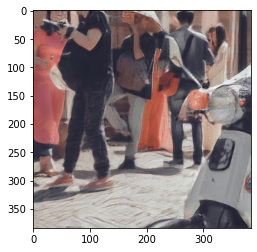

In [ ]:
import time
from PIL import Image
import matplotlib.pyplot  as plt
n_epoch = 500


save_dir = '/content/g_images'

device = 'cuda' if torch.cuda.is_available() else 'cpu'


G = Generator().to(device)
D = Discriminator().to(device)
G.load_state_dict(torch.load('/content/drive/MyDrive/G_250.pt'))
D.load_state_dict(torch.load('/content/drive/MyDrive/D_250.pt'))

G.train()
D.train()
vgg19 = vgg19.to(device)
vgg19.eval()

vgg_trans = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
#vgg19.train()
#torch.autograd.set_detect_anomaly(True)
#w = torch.tensor([1.0]).to(device)
#w.requires_grad = True

g_optimizer = torch.optim.Adam(G.parameters(), lr=1e-5)
d_optimizer = torch.optim.Adam(D.parameters(), lr=1e-5)


#w_optimizer = torch.optim.Adam([w], lr=1e-4)

g_scheduler = torch.optim.lr_scheduler.StepLR(g_optimizer, step_size=250, gamma=0.1)
d_scheduler = torch.optim.lr_scheduler.StepLR(d_optimizer, step_size=250, gamma=0.1)
## adversarial learning (G, D)
n_step_epoch = round(len(trainloader.dataset) // batch_size)
for epoch in range(250, 500):
    for step, (lr_patches, hr_patches) in enumerate(trainloader):
        if lr_patches.shape[0] != batch_size: # if the remaining data in this epoch < batch_size
            break
        
        lr_patches, hr_patches = lr_patches.to(device), hr_patches.to(device)
        step_time = time.time()

        #Train discriminator
        d_optimizer.zero_grad()  
        fake_patches = G(lr_patches) #Generate fake HR images
        logits_fake = D(fake_patches.detach())
        logits_real = D(hr_patches)
        d_loss1 = nn.BCEWithLogitsLoss()(logits_real, torch.ones_like(logits_real).to(device))
        d_loss2 = nn.BCEWithLogitsLoss()(logits_fake, torch.zeros_like(logits_fake).to(device))
        d_loss = d_loss1 + d_loss2

        d_loss.backward() 
        d_optimizer.step()

        #Train generator  
        #w_optimizer.zero_grad()
        g_optimizer.zero_grad()
        logits_fake = D(fake_patches) #D has been modified so must feed the patch through again        
        feature_fake = vgg19((vgg_trans(fake_patches+1)/2.)) # the pre-trained VGG uses the input range of [0, 1]
        feature_real = vgg19((vgg_trans(hr_patches.detach()+1)/2.))
        g_gan_loss = 1e-3 * nn.BCEWithLogitsLoss()(logits_fake, torch.ones_like(logits_fake).to(device))
        mse_loss = nn.MSELoss()(fake_patches, hr_patches.detach()) 
        vgg_loss = 0.006 * nn.MSELoss()(feature_fake, feature_real.detach())
        g_loss = mse_loss + vgg_loss + g_gan_loss

        
        g_loss.backward()  
        
        #w_optimizer.step()
        g_optimizer.step()         
        
        print("Epoch: [{}/{}] step: [{}/{}] time: {:.3f}s, g_loss(mse:{:6f}, vgg:{:.6f}, adv:{:.6f}) d_loss: {:.6f}".format(
            epoch, n_epoch, step, n_step_epoch, time.time() - step_time, mse_loss.item(), vgg_loss.item(), g_gan_loss.item(), d_loss.item()))
        
    #g_scheduler.step()
    #d_scheduler.step()
    #Save image    
    plt.imshow(((fake_patches[0] + 1.) / 2.).detach().cpu().numpy().transpose(1, 2, 0) )
    #if (epoch != 0) and (epoch % 10 == 0):
    plt.savefig(os.path.join(save_dir, 'train_g_{}.png'.format(epoch)))

In [ ]:
torch.save(G.state_dict(), '/content/drive/MyDrive/G_323.pt')
torch.save(D.state_dict(), '/content/drive/MyDrive/D_323.pt')

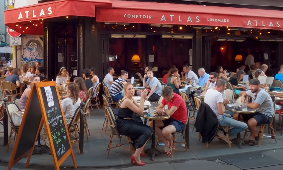

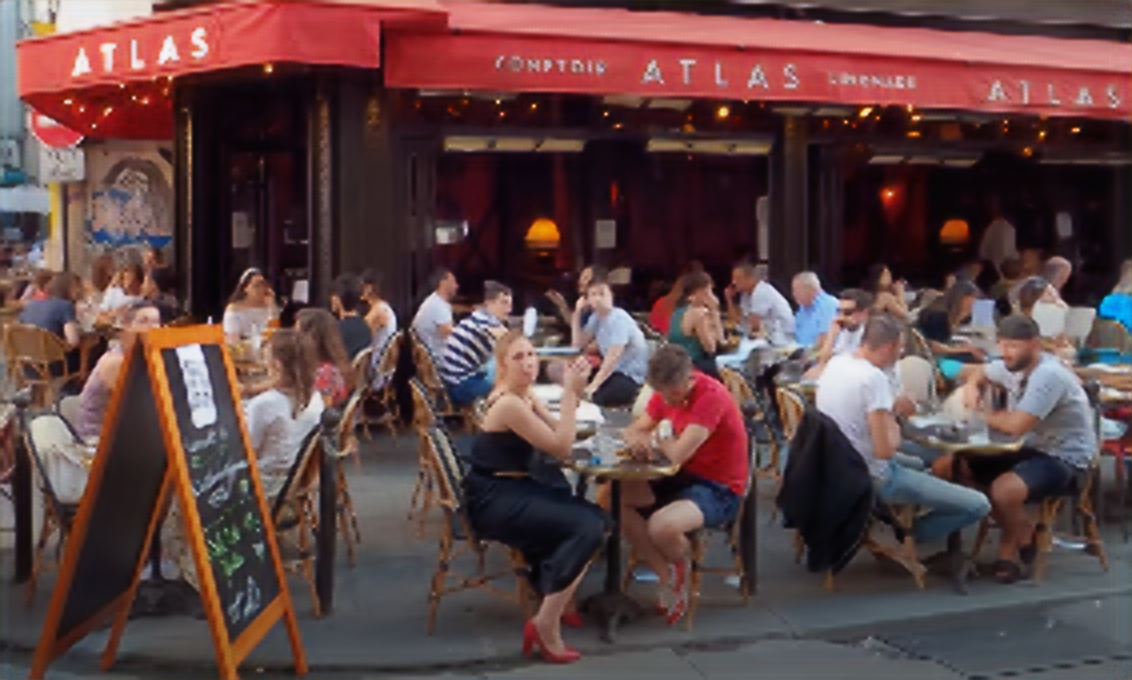

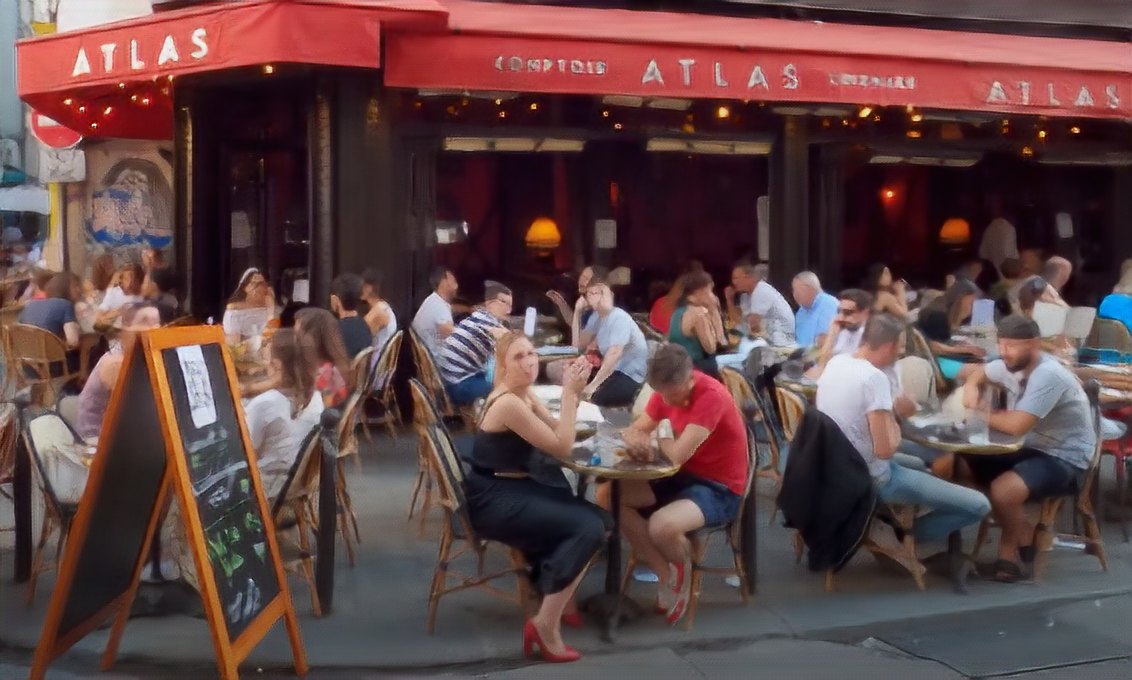

In [22]:
from PIL import Image
import matplotlib.pyplot  as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

with torch.no_grad():
    #im = Image.open("/content/DIV2K_valid_LR_bicubic/X4/0861x4.png")
    im = Image.open("/content/street_lr.png")
    display(im)
    G = Generator().to(device)    
    G.eval()    
    input = ToTensor()(im).unsqueeze(0).to(device)

    G.load_state_dict(torch.load('/content/drive/MyDrive/G_init.pt'))
    #print(input.shape)
    output = G(input)
    #print(output)
    #Draw image
    im = transforms.ToPILImage()((output[0] + 1.) / 2.)
    display(im)

    G.load_state_dict(torch.load('/content/drive/MyDrive/G_323.pt'))
    #print(input.shape)
    output = G(input)
    #print(output)
    #Draw image
    im = transforms.ToPILImage()((output[0] + 1.) / 2.)
    display(im)

    #im = Image.open("/content/DIV2K_valid_HR/0861.png")
    #display(im)



In [ ]:
import gc
del G
del D
del input
del output
gc.collect()

NameError: ignored

In [ ]:
!nvidia-smi

Thu Sep 23 18:07:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install torchviz